In [17]:
# Importing required libraries
import numpy as np
import os, cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns


In [25]:
def preprocess_image(img):
    # Denoise & enhance contrast
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.equalizeHist(img)
    img = cv2.Canny(img, 50, 150)     # Edge detection
    img = cv2.resize(img, (64, 64))
    return img


In [26]:
def load_images_from_folder(folder, label, limit=1000):
    data = []
    for filename in os.listdir(folder)[:limit]:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = preprocess_image(img)
            data.append((img.flatten(), label))
    return data


In [27]:
# Define your folder paths
train_cat_path = r"C:\Users\Harsh Jain\Desktop\INTERNSHIP_PROJECTS\Dataset\training_set\cats"
train_dog_path = r"C:\Users\Harsh Jain\Desktop\INTERNSHIP_PROJECTS\Dataset\training_set\dogs"

# Load cat and dog images
train_data = []
train_data += load_images_from_folder(train_cat_path, 0)
train_data += load_images_from_folder(train_dog_path, 1)

# Separate features and labels
X_train = np.array([i[0] for i in train_data])
y_train = np.array([i[1] for i in train_data])

print("✅ Training samples loaded:", len(X_train))


✅ Training samples loaded: 2000


In [28]:
# Create and train SVM classifier
svm = SVC(kernel='linear', random_state=42)
svm.fit(X_train, y_train)

print("✅ Model training completed.")


✅ Model training completed.


In [29]:
# Define your test folder paths
test_cat_path = r"C:\Users\Harsh Jain\Desktop\INTERNSHIP_PROJECTS\Dataset\test_set\cats"
test_dog_path = r"C:\Users\Harsh Jain\Desktop\INTERNSHIP_PROJECTS\Dataset\test_set\dogs"

# Load test data
test_data = []
test_data += load_images_from_folder(test_cat_path, 0)
test_data += load_images_from_folder(test_dog_path, 1)

# Separate features and labels
X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

print("✅ Test samples loaded:", len(X_test))
    

✅ Test samples loaded: 2000


📊 Accuracy: 0.551

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.56      0.55      1000
           1       0.55      0.54      0.55      1000

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.55      0.55      0.55      2000



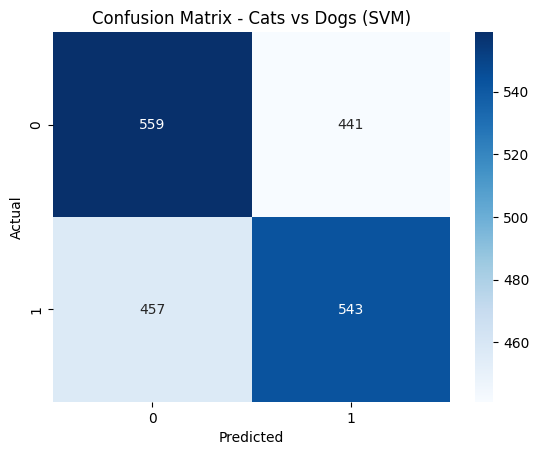

In [30]:
# Predict on test data
y_pred = svm.predict(X_test)

# Calculate accuracy and display results
print("📊 Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Cats vs Dogs (SVM)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


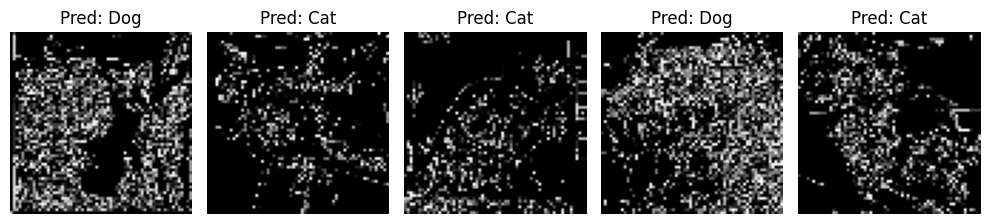

In [31]:
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(X_test[i].reshape(64, 64), cmap='gray')
    plt.title("Pred: " + ("Dog" if y_pred[i] else "Cat"))
    plt.axis('off')
plt.tight_layout()
plt.show()


✅ Data Loaded: Train = 2000, Test = 2000
Fitting 3 folds for each of 60 candidates, totalling 180 fits

✅ Best Parameters: {'pca__n_components': 200, 'svm__C': 10, 'svm__gamma': 'scale'}
✅ Best Cross-Validation Accuracy: 0.6285025655340498

📊 Test Accuracy: 0.6195

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.59      0.61      1000
           1       0.61      0.65      0.63      1000

    accuracy                           0.62      2000
   macro avg       0.62      0.62      0.62      2000
weighted avg       0.62      0.62      0.62      2000



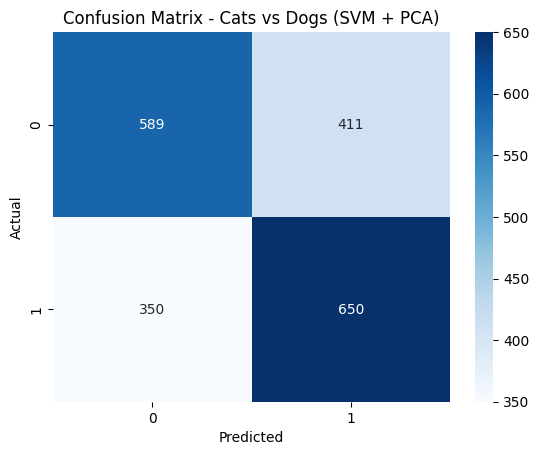

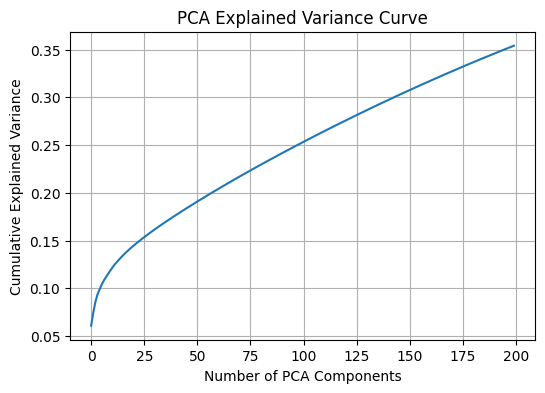

In [33]:
# --- CAT vs DOG CLASSIFIER WITH SCALING + PCA + RBF SVM ---

import numpy as np
import os, cv2
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# STEP 1: LOAD DATA
# -----------------------------
def preprocess_image(img):
    # Step 1: Reduce noise
    img = cv2.GaussianBlur(img, (3, 3), 0)

    # Step 2: Improve contrast
    img = cv2.equalizeHist(img)

    # Step 3: Edge detection to preserve shapes
    img = cv2.Canny(img, 50, 150)

    # Step 4: Resize to standard dimensions
    img = cv2.resize(img, (64, 64))
    return img

def load_images_from_folder(folder, label, limit=1000):
    data = []
    for filename in os.listdir(folder)[:limit]:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = preprocess_image(img)
            data.append((img.flatten(), label))
    return data

# Load train data
train_data = []
train_data += load_images_from_folder(train_cat_path, 0)
train_data += load_images_from_folder(train_dog_path, 1)

X_train = np.array([i[0] for i in train_data])
y_train = np.array([i[1] for i in train_data])

# Load test data
test_data = []
test_data += load_images_from_folder(test_cat_path, 0)
test_data += load_images_from_folder(test_dog_path, 1)

X_test = np.array([i[0] for i in test_data])
y_test = np.array([i[1] for i in test_data])

print(f"✅ Data Loaded: Train = {len(X_train)}, Test = {len(X_test)}")

# -----------------------------
# STEP 2: PIPELINE (Scaling + PCA + SVM)
# -----------------------------
pipe = Pipeline([
    ('scaler', StandardScaler()),                # Normalize pixel intensities
    ('pca', PCA(n_components=200, random_state=42)),  # Reduce features 4096 → 200
    ('svm', SVC(kernel='rbf'))
])

# -----------------------------
# STEP 3: GRID SEARCH
# -----------------------------
param_grid = {
    'pca__n_components': [100, 150, 200],
    'svm__C': [1, 5, 10, 50, 100],
    'svm__gamma': ['scale', 0.01, 0.005, 0.001]
}


grid = GridSearchCV(pipe, param_grid, cv=3, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

print("\n✅ Best Parameters:", grid.best_params_)
print("✅ Best Cross-Validation Accuracy:", grid.best_score_)

# -----------------------------
# STEP 4: TEST EVALUATION
# -----------------------------
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("\n📊 Test Accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Cats vs Dogs (SVM + PCA)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# -----------------------------
# STEP 5: PCA VARIANCE PLOT
# -----------------------------
pca = grid.best_estimator_.named_steps['pca']
plt.figure(figsize=(6,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of PCA Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance Curve')
plt.grid(True)
plt.show()
